# Setup

In [1]:
!pwd

/home/umni2/a/umnilab/users/verma99/mk/spr_4711/code


In [2]:
from setup import *

# Regional boundaries

In [3]:
scales = ['BG', 'Tract', 'County']

## Download data
Note that the TIGER/LINE boundaries and ACS data of the subdivisions of Indiana at different scales were already downloaded in [../../spr_4608/code/1_Geometry_ACS.ipynb](../../spr_4608/code/1_Geometry_ACS.ipynb), but they were for the year 2020 (I think). The files were then directly copied from `$MK/spr_4608/data/geometry` to `$MK/spr_4711/data/acs`.

However, since the UMN access data used the 2010 definitions, they are downloaded explicitly from the Census website.

In [4]:
!mkdir -p ../data/boundary

### Blocks

### Block groups

### Traffic analysis zones

### Tracts

### Counties

### CBSAs

## Combine scales

In [20]:
bound = gpd.read_parquet(P.data / 'export/boundaries.parquet').disp()

6,417 rows x 4 cols; Memory: 0.8 MiB; CRS: {"$schema": "https://proj.org/schemas/v0.5/projjson.schema.json", "type": "GeographicCRS", "name": "WGS 84", "datum_ensemble": {"name": "World Geodetic System 1984 ensemble", "members": [{"name": "World Geodetic System 1984 (Transit)"}, {"name": "World Geodetic System 1984 (G730)"}, {"name": "World Geodetic System 1984 (G873)"}, {"name": "World Geodetic System 1984 (G1150)"}, {"name": "World Geodetic System 1984 (G1674)"}, {"name": "World Geodetic System 1984 (G1762)"}, {"name": "World Geodetic System 1984 (G2139)"}], "ellipsoid": {"name": "WGS 84", "semi_major_axis": 6378137, "inverse_flattening": 298.257223563}, "accuracy": "2.0", "id": {"authority": "EPSG", "code": 6326}}, "coordinate_system": {"subtype": "ellipsoidal", "axis": [{"name": "Geodetic latitude", "abbreviation": "Lat", "direction": "north", "unit": "degree"}, {"name": "Geodetic longitude", "abbreviation": "Lon", "direction": "east", "unit": "degree"}]}, "scope": "Horizontal comp

,scale,geoid,county,geometry
,<category>,<category>,<category>,<geometry>
0,County,18083,Knox County,"POLYGON ((-87.506221 38.733533, -87.506172 38...."


# ACS data

## Find variables of interest

In [37]:
acsCols = pd.read_csv(P.data / 'acs/acs_variables_description.csv').disp(5)

27,014 rows x 8 cols; Memory: 14.6 MiB


,field_id,field_label,grp_label,grp_id,grp_type,grp_body,grp_suffix,sub_id
,<object>,<object>,<object>,<object>,<object>,<object>,<object>,<int64>
0,B01001A_001E,Total,SEX BY AGE (WHITE ALONE),B01001A,B,1001,A,1
1,B01001A_002E,Total__Male,SEX BY AGE (WHITE ALONE),B01001A,B,1001,A,2
2,B01001A_003E,Total__Male__Under 5 years,SEX BY AGE (WHITE ALONE),B01001A,B,1001,A,3
3,B01001A_004E,Total__Male__5 to 9 years,SEX BY AGE (WHITE ALONE),B01001A,B,1001,A,4
4,B01001A_005E,Total__Male__10 to 14 years,SEX BY AGE (WHITE ALONE),B01001A,B,1001,A,5


## Download data
For 2019

In [6]:
def download_acs(scale, year=2020, state=18, root=U.mkdir(P.data / 'geometry'),
                 fields=mk.acs.IMP_FIELDS):
    scale = scale.lower()
    assert scale in ['county', 'tract', 'bg', 'city']
    # download the ACS data
    geo = {'state': f'{state:02}'} | dict(
        county={'county': '*'},
        tract={'county': '*', 'tract': '*'},
        bg={'county': '*', 'tract': '*', 'block group': '*'}
    )[scale]
    fields = {
        'B01001_001E': 'population',
        'B24080_001E': 'num_workers'
    }
    acs = (mk.acs.download(list(geo.items()), list(fields.keys()), year=year)
           .rename(columns=fields).reorder_levels(list(geo.keys())))
    acs.index = acs.index.map(''.join).rename('geoid')
    acs = acs.fillna(0).astype(int)
    return acs
    
%time df = download_acs('bg'); df

CPU times: user 64.1 ms, sys: 2.93 ms, total: 67 ms
Wall time: 953 ms


,population,num_workers
geoid,,
180050102001,627,351
180050102004,1773,946
180050104001,2875,1097
180050105001,1141,515
180050105004,885,352
...,...,...
181670018001,939,295
181670018003,578,382
181670019002,559,200


## Rebase geoids
Find the mapping between the latest ACS data's geoids and the 2010 geoids used in the AAA data.

In [7]:
def rebase_acs_geoid(scale, acs_year=2020):
    geo10 = (gpd.read_file(P.data / f'boundary/{scale.lower()}.geojson')
             .rename(columns={'geoid': 'geoid10'})[['geoid10','geometry']])
    acs20 = download_acs(scale, year=acs_year)
    acs20_shp = (gpd.read_file(P.data / f'acs/{scale.lower()}.gpkg')
                 [['geoid','geometry']].astype({'geoid': str}))
    acs20 = acs20_shp.merge(acs20, on='geoid').rename(columns={'geoid': 'geoid20'})
    ixn = acs20.overlay(geo10, how='intersection', keep_geom_type=False)
    ixn['area'] = ixn.to_crs(CRS_M).area
    acs = (ixn.sort_values('area').groupby('geoid20').last().reset_index()
           .groupby('geoid10')[acs20.columns].sum(numeric_only=True)
           .rename_axis('geoid').reset_index())
    return acs

# %time x = rebase_acs_geoid('tract'); x

In [8]:
acs = pd.read_csv(P.data / 'export/acs.csv').disp()

6,314 rows x 4 cols; Memory: 0.5 MiB


,SCALE,GEOID,POPULATION,NUM_WORKERS
,<object>,<int64>,<int64>,<int64>
0,BG,180010301001,1349,556


# AAA data
**Access Across America (AAA)** from [**Accessibility Observatory**](https://ao.umn.edu/) at the University of Minnesota

* **[Available datasets](https://ao.umn.edu/data/datasets)**
* **[Methodology report for transit access](https://ao.umn.edu/research/america/transit/2019/documents/AccessAcrossAmerica-Transit2019-Methodology.pdf)**
* **[Transit data documentation](https://conservancy.umn.edu/bitstream/handle/11299/218072/2019DataDoc_all_LEHD.pdf?sequence=51&isAllowed=y)**

## Download

### [Transit (2019)](https://conservancy.umn.edu/handle/11299/218072) – Indiana

### [Bike (2019)](https://conservancy.umn.edu/handle/11299/218194) – Indiana

### [Walk (2014)](https://conservancy.umn.edu/handle/11299/173991) – Indianapolis

## Extract layers

In [9]:
import fiona

In [10]:
def get_aaa_layers(mode, year=2017):
    mode = mode.lower()
    assert mode in ['bike', 'transit']
    fpath = P.data / f'aaa/{mode}/indiana.gpkg'
    year = str(year % 2000)
    for layer in tqdm(fiona.listlayers(fpath)):
        if not layer.startswith(mode[:2] + '_'): continue
        tt = int(layer.split('_')[1])
        df = gpd.read_file(fpath, layer=layer).astype({'blockid': int})
        df = df.set_index('blockid').rename_axis('geoid')
        df = df.filter(like=f'_{year}').astype(np.int32)
        df = df.rename(columns=lambda x: x.replace(f'_{year}', ''))
        df.to_parquet(P.data / f'aaa/{mode}/{tt:02}_min.parquet')
    
# %time x = get_aaa_layers('bike'); x

**TRANSIT**

In [11]:
# get_aaa_layers('transit') # t=9:16

**BIKE**

In [12]:
# get_aaa_layers('bike') # t=8:32

## Categories
**[Columns documentation](https://conservancy.umn.edu/bitstream/handle/11299/218072/2019DataDoc_all_LEHD.pdf?sequence=51&isAllowed=y)**

In [13]:
lehd_cat_vars = {
    'Overall': {
        'c000': 'Total'
    },
    'Age': {
        'ca01': 'Young (≤ 29 y)',
        'ca02': 'Middle age (30–54 y)',
        'ca03': 'Senior (≥ 55 y)'
    },
    'Sex': {
        'cs01': 'Male',
        'cs02': 'Female'
    },
    'Race': {
        'cr01': 'White', # White, Alone
        'cr02': 'Black', # Black or African American, Alone
        'cr03': 'Native', # American Indian or Alaska Native Alone
        'cr04': 'Asian', # Asian, Alone
        'cr05': 'Pacific', # Native Hawaiian or Other Pacific Islander, Alone
        'cr07': 'Multiple' # Two or More Race Groups
    },
    'Education': {
        'cd01': 'Less than high school', # Less than high school
        'cd02': 'Up to high school', # High school or equivalent, no college
        'cd03': 'Some college degree', # Some college or Associate degree
        'cd04': "Bachelor's degree or more", # Bachelor's degree or advanced degree
    },
    'Job earnings': {
        'ce01': 'Low (<$1,250/mo)', # jobs with earnings $1250/month or less
        'ce02': 'Medium ($1,250–$3,333/mo)', # jobs with earnings $1251/mo. to $3333/mo.
        'ce03': 'High (>$3,333/mo)' # jobs with earnings greater than $3333/month
    },
    'Job category': {
        'cns01': '11: Agriculture, Forestry, Fishing, Hunting',
        'cns02': '21: Mining, Quarrying, and Oil and Gas Extraction',
        'cns03': '22: Utilites',
        'cns04': '23: Construction',
        'cns05': '31-33: Manufacturing',
        'cns06': '42: Wholesale Trade',
        'cns07': '44-45: Retail Trade',
        'cns08': '48-49: Transportation and Warehousing',
        'cns09': '51: Information',
        'cns10': '52: Finance and Insurance',
        'cns11': '53: Real Estate and Rental and Leasing',
        'cns12': '54: Professional, Scientific, and Technical Services',
        'cns13': '55: Management of Companies and Enterprises',
        'cns14': '56: Admin & Support, Waste Mngmt, Remediation Services',
        'cns15': '61: Educational Services',
        'cns16': '62: Health Care and Social Assistance',
        'cns17': '71: Arts, Entertainment, and Recreation',
        'cns18': '72: Accommodation and Food Services',
        'cns19': '81: Other Services [except Public Administration]',
        'cns20': '92: Public Administration',
    },
    # 'Firm age': {
    #     'cfa01': '0-1 Years',
    #     'cfa02': '2-3 Years',
    #     'cfa03': '4-5 Years',
    #     'cfa04': '6-10 Years',
    #     'cfa05': '11+ Years'
    # },
    # 'Firm size': {
    #     'cfs01': '0-19',
    #     'cfs02': '20-49',
    #     'cfs03': '50-249',
    #     'cfs04': '250-499',
    #     'cfs05': '500+'
    # }
}

## Get useful info
Description of LODES columns: https://lehd.ces.census.gov/data/lodes/LODES7/LODESTechDoc7.4.pdf

In [14]:
def get_aaa_tables(scale, mode, tt_thresh, cat_vars=lehd_cat_vars):
    scale, mode = scale.lower(), mode.lower()
    assert scale in ['bg', 'county', 'tract', 'taz']
    assert mode in ['bike', 'transit', 'county']
    df = pd.read_parquet(P.data / f'aaa/{mode}/{tt_thresh}_min.parquet')
    digits = dict(block=15, bg=12, tract=11, county=5)[scale]
    df.index = df.index.astype(str).str.slice(0, digits).rename('geoid')
    df = df.groupby('geoid').sum().astype(np.int32)
    res = []
    for is_rac, prefix in [(False, 'w_'), (True, 'r_')]:
        res.append(df.filter(like=prefix).reset_index()
                   .rename(columns=lambda x: x.replace(prefix, ''))
                   .assign(**{'is_rac': is_rac}))
    df = (pd.concat(res).set_index(['is_rac', 'geoid'])
          .fillna(0).astype(np.int32))
    res = []
    for cat, x in cat_vars.items():
        d = df[x.keys()].rename(columns=x)
        # d['Total'] = d.sum(1)
        d = d.reset_index()
        d = d.melt(['is_rac','geoid'], var_name='subcategory', value_name='num_jobs')
        d['category'] = cat
        res.append(d)
    res = (pd.concat(res).reset_index(drop=True)
           [['is_rac','category','subcategory','geoid','num_jobs']])
    return res

%time x = get_aaa_tables('bg', 'transit', 30).disp(2)

375,258 rows x 5 cols; Memory: 80.3 MiB


,is_rac,category,subcategory,geoid,num_jobs
,<bool>,<object>,<object>,<object>,<int32>
0,False,Overall,Total,180010301001,620
1,False,Overall,Total,180010301002,783


CPU times: user 1.07 s, sys: 363 ms, total: 1.43 s
Wall time: 827 ms


## Prepare a single file for export

In [15]:
modes = ['Bike', 'Transit']
travel_times = [15, 30, 45, 60]

In [24]:
def get_aaa_overall(scales, modes, travel_times, save=True, overwrite=False):
    outfile = P.data / 'export/aaa.parquet'
    if outfile.exists() and not overwrite:
        return pd.read_parquet(outfile)
    res = []
    for scale in tqdm(scales):
        for mode in modes:
            for tt in travel_times:
                df = get_aaa_tables(scale, mode, tt)
                df = df.assign(mode=mode, scale=scale, tt_thresh=tt)
                res.append(df)
    df = pd.concat(res).reset_index(drop=True)
    df = df.astype({x: 'category' for x in [
        'category', 'subcategory', 'geoid', 'mode', 'scale', 'tt_thresh']})
    df = df[['scale', 'mode', 'tt_thresh', 'is_rac',
             'category', 'subcategory', 'geoid', 'num_jobs']]
    df = df.rename(columns=str.upper)
    if save:
        df.to_parquet(U.mkdir(outfile.parent) / outfile.name)
    return df

%time x = get_aaa_overall(scales, modes, travel_times).disp() # t=0:17

4,000,464 rows x 8 cols; Memory: 73.2 MiB


,MODE,SCALE,TT_THRESH,IS_RAC,CATEGORY,SUBCATEGORY,GEOID,NUM_JOBS
,<category>,<category>,<int64>,<bool>,<category>,<category>,<category>,<int32>
0,Bike,BG,15,False,Overall,Total,180010301001,154


CPU times: user 549 ms, sys: 223 ms, total: 772 ms
Wall time: 211 ms


# Visualize

In [9]:
bg = gpd.read_file(P.data / 'boundary/bg.geojson').disp()

4,814 rows x 5 cols; Memory: 0.7 MiB; CRS: epsg:4326


,geoid,name,aland,awater,geometry
,<object>,<object>,<int64>,<int64>,<geometry>
0,181379685003,Block Group 3,2566010,39626,"POLYGON ((-85.20815 39.304011, -85.208134 39.3..."


RAC: µ=12,386.8, σ=13,516.0
WAC: µ=27,374.5, σ=213,110.2


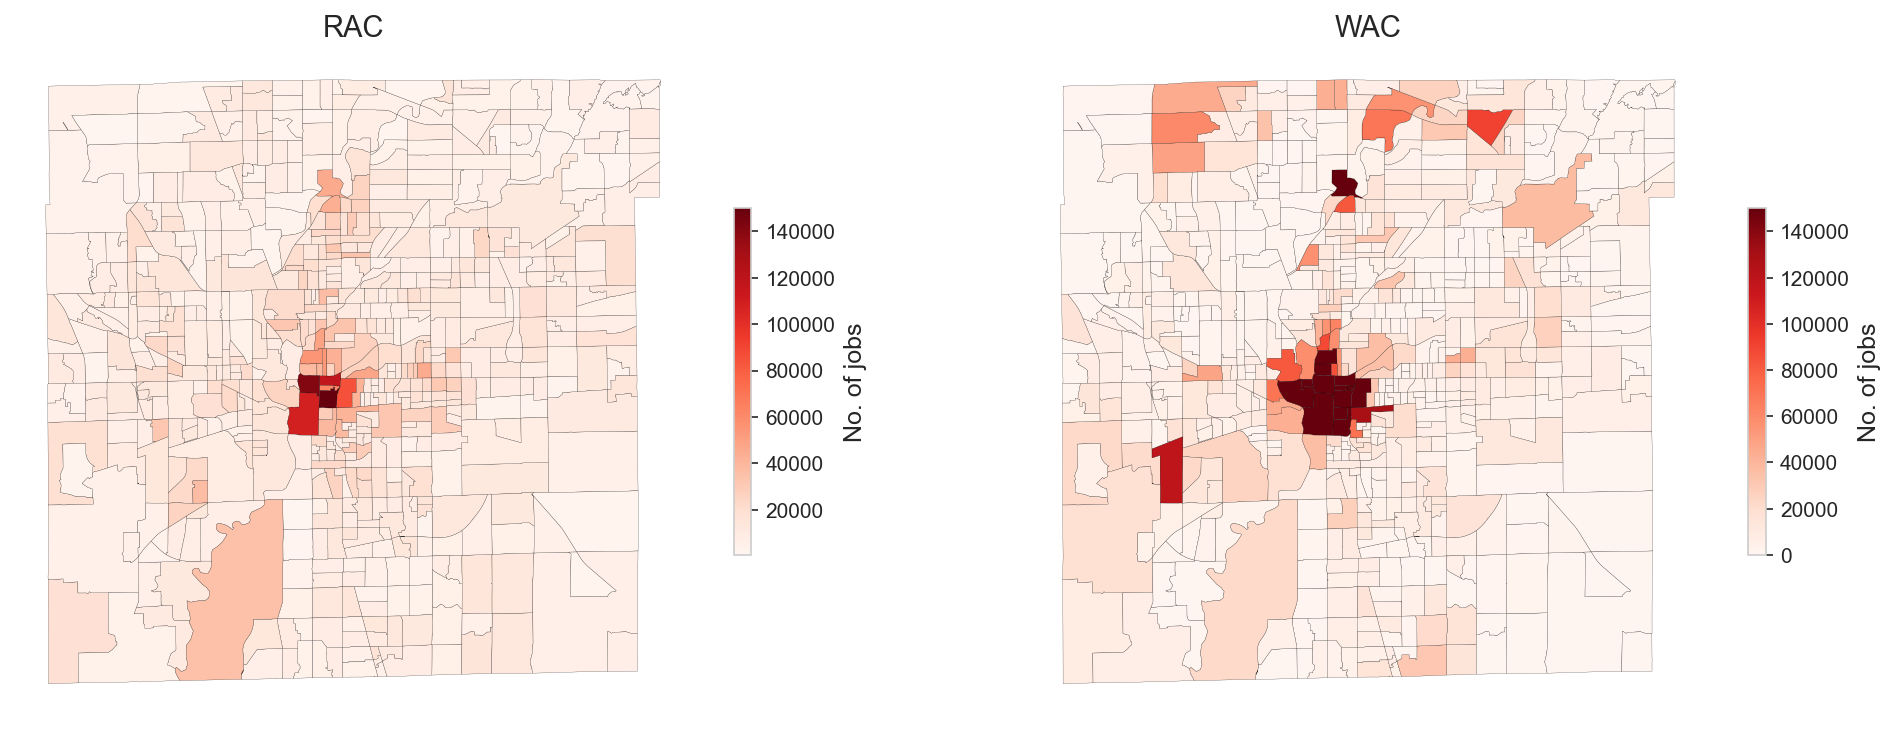

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), dpi=150)
df = x.loc[x.geoid.astype(str).str.slice(0, 5).pipe(lambda x: x[x == '18097']).index]
df = bg[['geoid','geometry']].merge(df, on='geoid')
for (var, df2), ax in zip(df.groupby('variable'), axes):
    df2.plot(ax=ax, column='c000', cmap='Reds', linewidth=0.1, edgecolor='k', vmax=150000,
             legend=True, legend_kwds=dict(shrink=0.5, label='No. of jobs'))
    U.plot(ax, axoff=1, title=var.upper())
    print(f'{var.upper()}: µ={df2.c000.mean():,.1f}, σ={df2.c000.std():,.1f}')

In [9]:
def f(d, tol0=1e-8):
    df = Pdf().assign(**{
        'total': d.c000,
        'total.age': d.ca02 + d.ca02 + d.ca03,
        'total.sex': d.cs01 + d.cs02,
        'pct_young': d.ca01 * 100 / (d.ca02 + d.ca02 + d.ca03),
        'pct_old': d.ca03 * 100 / (d.ca02 + d.ca02 + d.ca03),
        'pct_female': d.cs02 * 100 / (d.cs01 + d.cs02)
    })
    return df

%time f(x)

CPU times: user 31.5 ms, sys: 32.2 ms, total: 63.6 ms
Wall time: 44.1 ms


,total,total.age,total.sex,pct_young,pct_old,pct_female
0,0,0,0,NaN,NaN,NaN
1,0,0,0,NaN,NaN,NaN
2,0,0,0,NaN,NaN,NaN
3,0,0,0,NaN,NaN,NaN
4,0,0,0,NaN,NaN,NaN
...,...,...,...,...,...,...
513331,9,12,9,25.000000,0.000000,55.555556
513332,3,5,3,0.000000,20.000000,33.333333
513333,4,3,4,66.666667,33.333333,75.000000
513334,0,0,0,NaN,NaN,NaN


In [10]:
f(x).describe()

,total,total.age,total.sex,pct_young,pct_old,pct_female
count,513336.000000,513336.000000,513336.000000,3.579750e+05,355429.000000,357987.000000
mean,241.414576,309.180470,241.382461,inf,20.603209,48.332639
std,1029.983300,1425.941786,1029.957242,NaN,14.562983,18.034763
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.296890e+01,15.254237,42.857143
50%,31.000000,39.000000,31.000000,1.842105e+01,18.518519,49.264706
75%,271.000000,342.000000,271.000000,2.380952e+01,22.429907,55.405405
max,75615.000000,106923.000000,75614.000000,inf,100.000000,100.000000


In [12]:
acs_cols = ['popu','hh','age_adult','age_senior','sex_female','sex_male','race_white','race_black']

In [13]:
def get_transit_aaa(scale, travel_times=[10, 30, 45, 60], lehd_cols=lehd_cols,
            acs_cols=acs_cols, save=True):
    assert scale in ['bg', 'tract', 'county']
    # acs = (gpd.read_file(P.data / f'ACS/{scale}.gpkg')
    #        .query('popu > 0').drop(columns=['namelsad','awater'])
    #        .astype({'geoid': str}).set_index('geoid')
    #        [acs_cols + ['aland','geometry']])
    res = []
    for tt in travel_times:
        df = pd.read_parquet(P.data / f'AAA/transit/tr_{tt}_minutes.parquet')
        df2 = []
        for old, new in lehd_cols.items():
            df2.append(df['w_' + old].rename('Jobs__' + new))
            df2.append(df['r_' + old].rename('Workers__' + new))
        df = pd.concat(df2, axis=1)
        df = df[sorted(df)]
        digits = {'bg': 12, 'tract': 11, 'county': 5}[scale]
        df.index = df.index.astype(str).str.slice(0, digits).rename('geoid')
        df = df.groupby('geoid').sum().astype(np.int32)
        df = df.reset_index().melt('geoid')
        df['travel_time'] = tt
        res.append(df.reset_index())
    # df = acs.merge(pd.concat(res), on='geoid')
    if save:
        df.to_csv(P.data / f'AAA/transit/{scale}.csv', index=False)
    return df
    
%time x = get_transit_aaa('tract', save=False); x # t=40s

KeyError: 'r_cfa01'

In [ ]:
%time x = get_transit_aaa('bg') # t=38s
%time x = get_transit_aaa('tract') # t=20s
%time x = get_transit_aaa('county') # t=7s

**WALK**

In [12]:
def get_aaa_walk_layers():
    df = (gpd.read_file(P.data / 'aaa/walk/26900_wa_2014_0700-0700.shp')
          .rename(columns=str.lower).astype({'jobs_tot': int})
          .rename(columns={'geoid10': 'geoid'}))
    return df.to_crs(CRS_M)

%time x = get_aaa_walk_layers().disp()

45,032 rows x 3 cols; Memory: 3.8 MiB; CRS: EPSG:3857


,geoid,jobs_tot,geometry
,<object>,<int64>,<geometry>
0,180118106013110,414,"POLYGON ((-9612077.354849 4864152.132155, -961..."


CPU times: user 3.01 s, sys: 125 ms, total: 3.13 s
Wall time: 3.24 s


CPU times: user 16.8 s, sys: 4.79 s, total: 21.6 s
Wall time: 14.1 s


<Axes: >

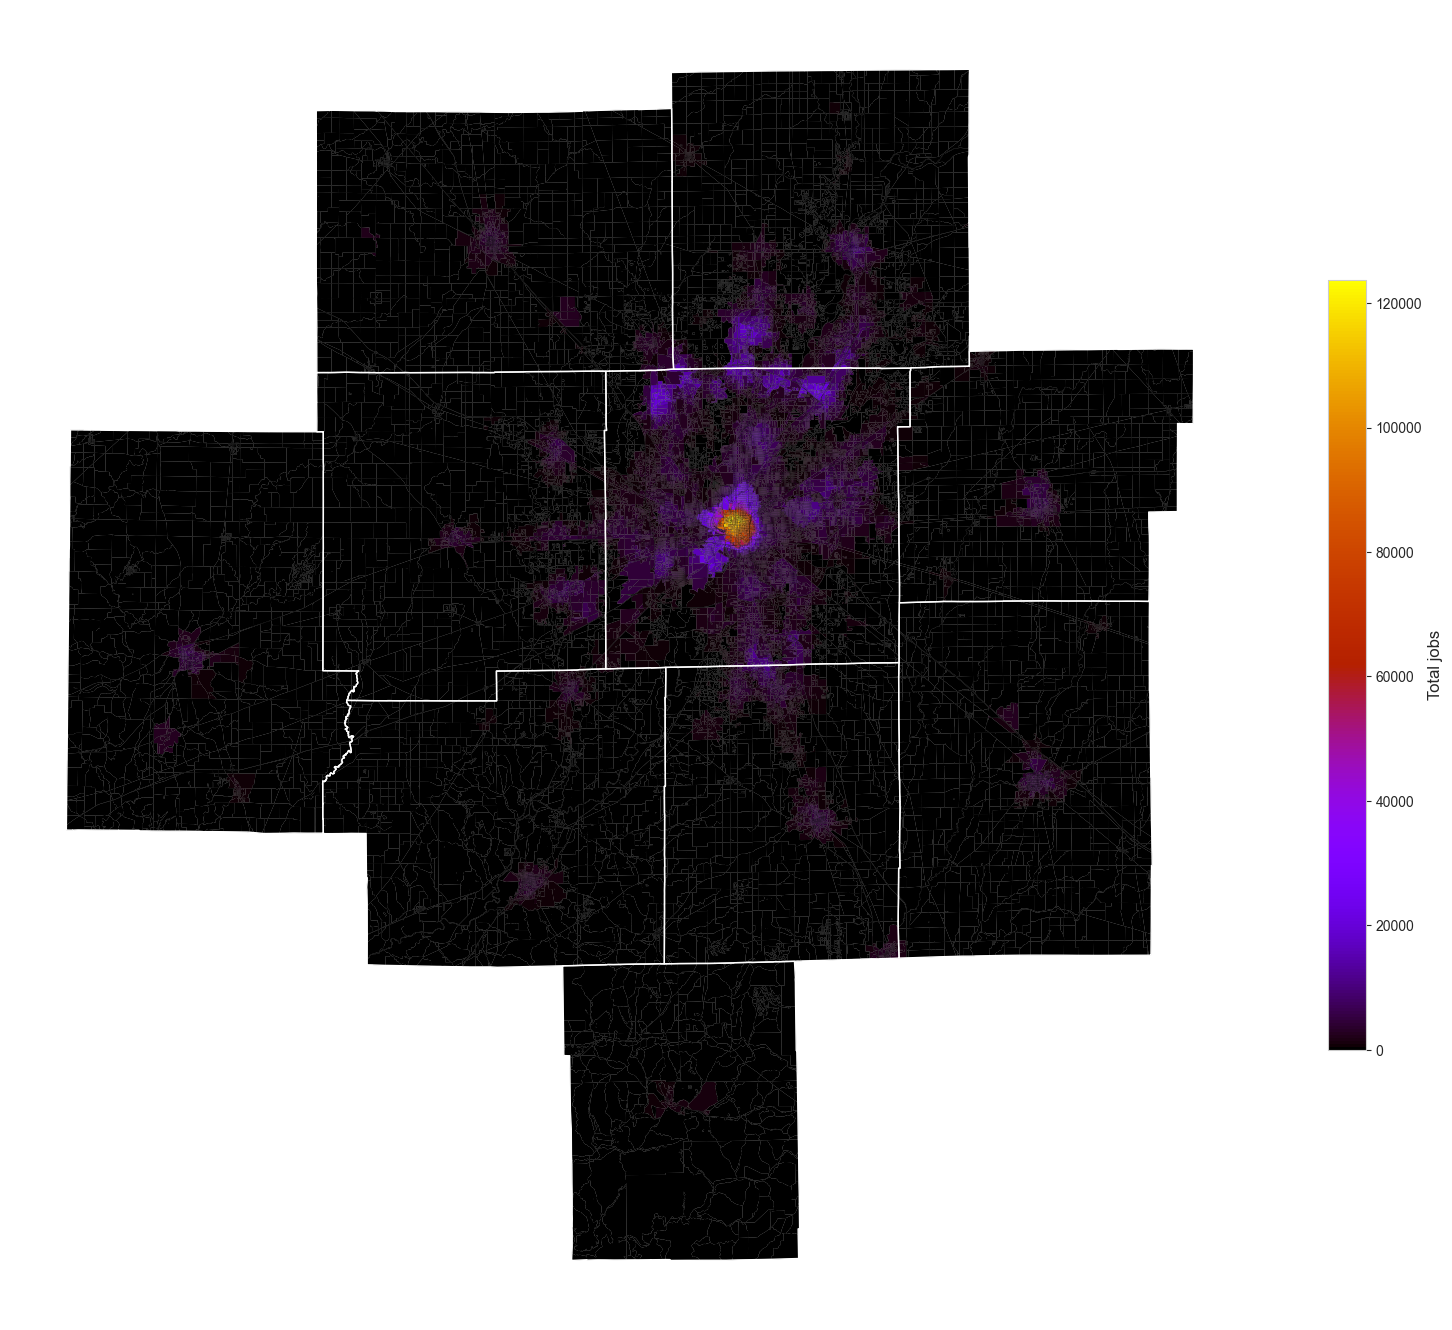

In [13]:
%%time
# t=14s
ax = U.plot(size=(20, 20), dpi=100, axoff=1)
x.plot(ax=ax, column='jobs_tot', cmap='gnuplot',
       edgecolor='k', linewidth=0.1, legend=True,
       legend_kwds=dict(shrink=0.5, label='Total jobs'))
(x.assign(geoid=x.geoid.str.slice(0, 5))
 .groupby('geoid')['geometry'].agg(lambda x: x.unary_union)
 .plot(ax=ax, facecolor='none', edgecolor='w'));

In [25]:
df = gpd.read_file(P.data / 'AAA/county.geojson').disp(3)

DriverError: /home/umni2/a/umnilab/users/verma99/mk/spr_4711/data/AAA/county.geojson: No such file or directory

NameError: name 'd2' is not defined

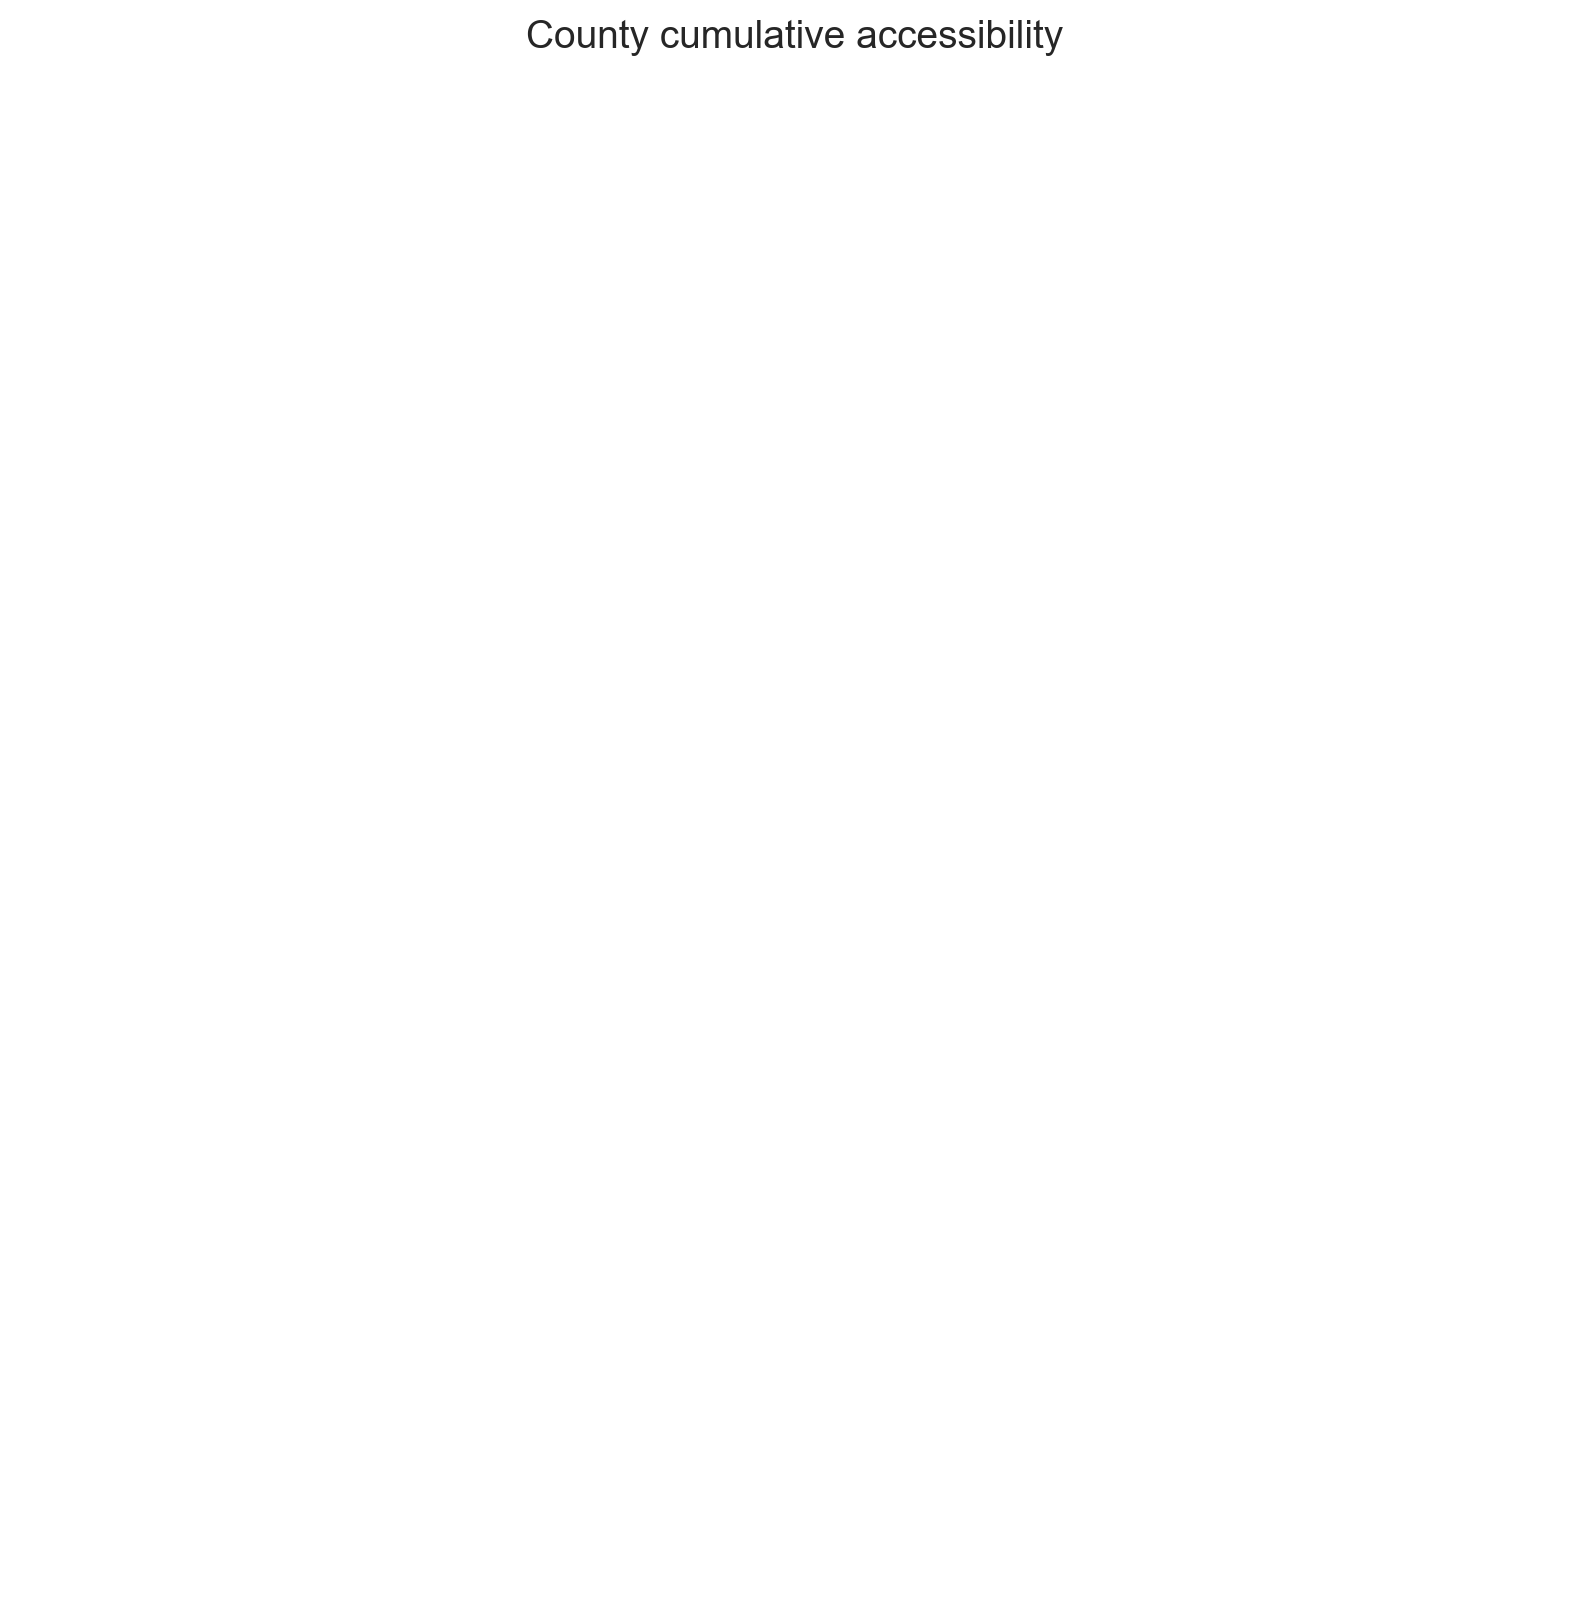

In [26]:
ax = U.plot(size=(10, 10), dpi=200, axoff=1, title='County cumulative accessibility')
d2.to_crs(CRS_M).plot(ax=ax, column='w_c000_17', cmap='gnuplot', legend=True, 
                      legend_kwds=dict(label='No. of jobs accessible from county', shrink=0.5));

In [ ]:
in_bg = gpd.read_file(MK / 'spr_4608/data/geometry/bg.gpkg')

In [27]:
in_cnty = Gdf(in_bg.assign(county = lambda df: df['geoid'].astype(str).str.slice(0, 5))
              .groupby('county')['geometry'].agg(lambda x: x.unary_union)
              .reset_index()).set_crs(CRS_DEG).to_crs(CRS_M).disp()

NameError: name 'in_bg' is not defined

In [28]:
in_tract = Gdf(in_bg.assign(tract = lambda df: df['geoid'].astype(str).str.slice(0, 9))
               .groupby('tract').agg({'aland': sum, 'popu': sum, 'geometry': lambda x: x.unary_union})
               .assign(pop_density = lambda df: df['popu']/ (df['aland'] * U.SQM2SQMI))
               .reset_index(), crs=CRS_DEG).to_crs(CRS_M).disp()

NameError: name 'in_bg' is not defined

In [29]:
in_tract = in_tract.merge(
    d1.assign(tract = lambda df: df['blockid'].str.slice(0, 9))
    .groupby('tract')['w_c000_17'].sum().rename('n_jobs').reset_index(), on='tract'
).assign(job_density = lambda df: df['n_jobs'] / df['popu']).disp()

NameError: name 'in_tract' is not defined

NameError: name 'in_tract' is not defined

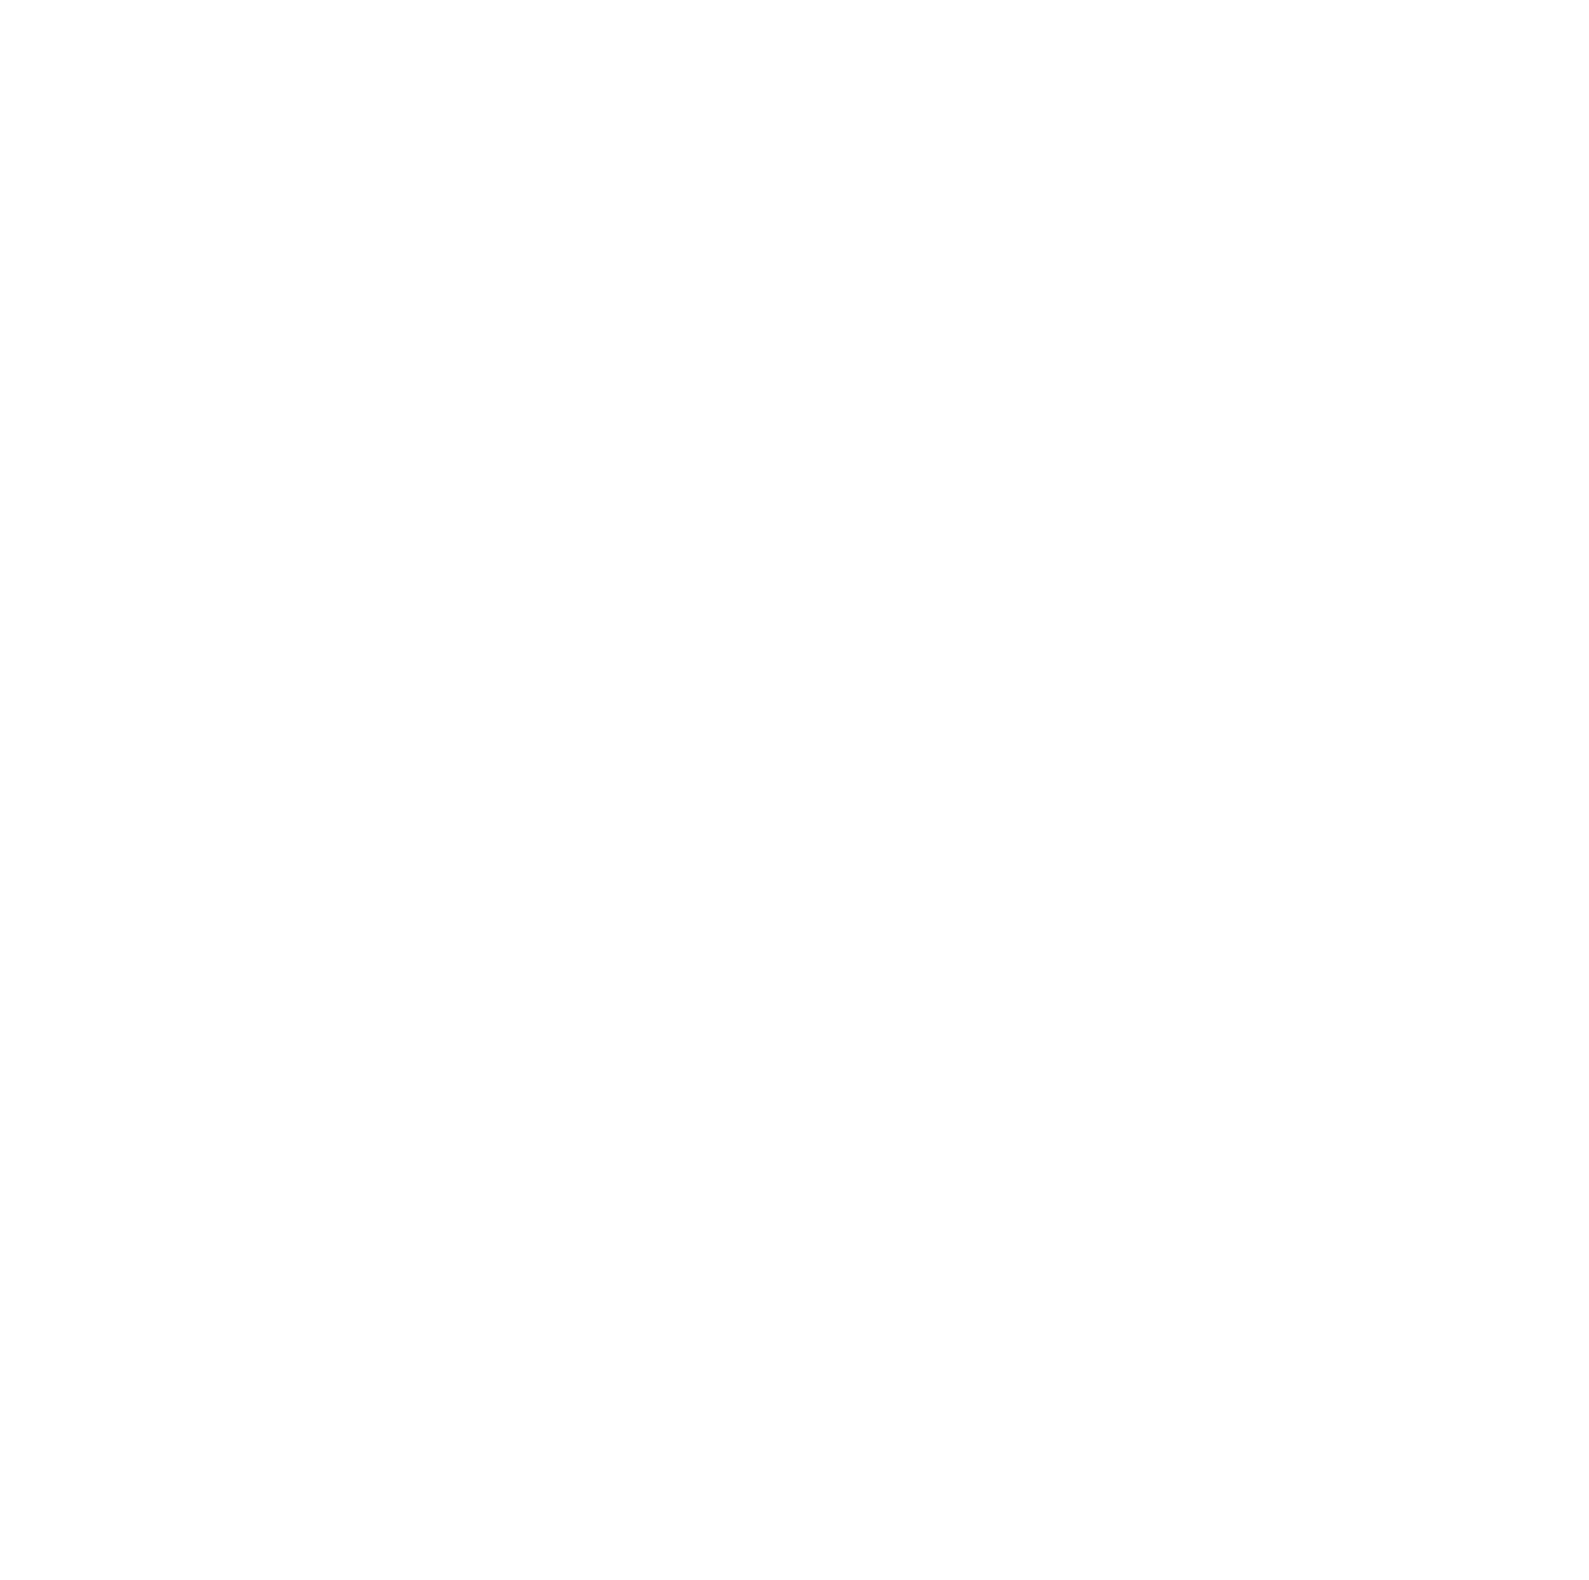

In [30]:
ax = U.plot(size=(10, 10), dpi=200, axoff=1)
in_tract.plot(ax=ax, column='job_density', cmap='Greens', legend=True, linewidth=0.1, edgecolor='k',
              legend_kwds=dict(label='No. of jobs accessible per worker', shrink=0.5), vmax=100)
in_cnty.plot(ax=ax, facecolor='none', edgecolor='k', linewidth=1);